In [109]:
!pip install datasets
!pip install gdown

In [110]:
import sys, os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import argparse
import logging

import torch.nn as nn
from torchvision import models
import torchvision.transforms as T
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader

import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import gdown

SEED = 42
TOL_FP = 1e-12

plt.rc('font', size=18)#weight='bold',
plt.rc('legend', fontsize=18)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Dataloader

Dataset size: 23708
Age: 82


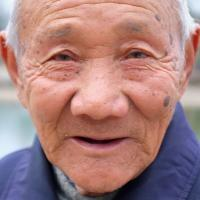

In [111]:
dataset = load_dataset("py97/UTKFace-Cropped")['train']
print(f'Dataset size: {len(dataset):d}')
sample = dataset[0] # Change the index here to check different samples
age = (sample['__key__'].split('_')[0]).split('/')[-1]
age = float(age)
print(f'Age: {age:.0f}')
sample['jpg.chip.jpg']

In [112]:
transform = T.Compose([
    T.Resize((224, 224)),           # 128 or 224, etc.
    T.ToTensor(),                   # Convert to a torch.Tensor
    # T.Normalize(mean=[0.5, 0.5, 0.5],
                # std=[0.5, 0.5, 0.5]) # Example normalization
])

class UTKFaceDataset(Dataset):
    """
    UTKFace images are typically named in the format:
      [age]_[gender]_[race]_[date].jpg
    This dataset parses the 'age' from the filename and
    returns (image, age) for each sample.
    """
    def __init__(self, transform=transform):
        self.dataset = load_dataset("py97/UTKFace-Cropped")['train']
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['jpg.chip.jpg']
        age = float((sample['__key__'].split('_')[0]).split('/')[-1])

        if self.transform:
            image = self.transform(image)

        return image, age

def get_utkface_train_test_loader(batch_size=32, test_size=0.2, seed=42):
    """
    Helper function to return train and test data loaders.
    """
    train_idx, test_idx = train_test_split(
        list(range(23708)), test_size=test_size, random_state=seed)

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, test_loader

In [113]:
dataset = UTKFaceDataset()
train_loader, test_loader = get_utkface_train_test_loader(batch_size=32, test_size=0.2, seed=42)

# Quick check
for batch_images, batch_ages in train_loader:
    print("Image batch shape:", batch_images.shape)  # e.g. [32, 3, 64, 64]
    print("Age batch shape:", batch_ages.shape)      # e.g. [32]
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Age batch shape: torch.Size([32])


# Extract pre-trained representations

## Compute CLIP representations
ALERT: This inference step can take some (a lot of) time, especially on Colab! If this is a concern for you, skip this cell. You can download the precomputed representations using the Google drive URLs provided below.

In [ ]:
# 1) Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# We'll focus on the vision encoder part
vision_encoder = clip_model.vision_model

# 2) Freeze
vision_encoder.eval()
for param in vision_encoder.parameters():
    param.requires_grad = False

# 3) (Optional) GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vision_encoder.to(device)

# Suppose 'dataset' yields PIL images + labels
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_features_clip = []
with torch.no_grad():
    for pil_images, _ in data_loader:
        # 4) Use the CLIP processor or transform to get pixel_values
        #    Usually you'd do something like:
        inputs = processor(images=pil_images, return_tensors="pt", do_rescale=False)
        pixel_values = inputs["pixel_values"].to(device)  # (B, 3, 224, 224)

        # 5) Forward through CLIP's vision encoder
        outputs = vision_encoder(pixel_values=pixel_values)

        # 6) outputs has .last_hidden_state and .pooler_output
        #    .pooler_output is usually the [CLS] embedding, shape (B, hidden_size)
        feats = outputs.pooler_output  # shape (B, 768) for ViT-B/32

        all_features_clip.append(feats.cpu())

features = torch.cat(all_features_clip, dim=0)  # (N, 768)
print("CLIP feature matrix shape =", features.shape)

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
all_labels = []
for _, labels in data_loader:
    all_labels.append(labels)
all_labels = torch.cat(all_labels, dim=0)

torch.save(all_labels, "./utkface_labels.pt")
torch.save(features, "./utkface_clipb32.pt")
features = torch.load("./utkface_clipb32.pt")
labels = torch.load("./utkface_labels.pt")

## Download CLIP representations
- `clip_features` now contains our feature matrix $X \in \mathbb{R}^{n \times d}$, consisting of $n=23708$ samples, each corresponding to a feature (a CLIP representation vector) of dimension $d=768$.
- `labels` is a vector (`torch.Tensor`) of dimension $n=23708$ consisting of the age labels for all samples.

In [114]:
clip32_id = '1YP_CF0asQb35haTCoaVpkelFsdAeQSnc'
clip32_path = './utkface_clipb32.pt'
lable_id = '1YPnbh1DqfkdjREkH7kfY37G7nyd1c95k'
lable_path = './utkface_labels.pt'

if not os.path.exists(clip32_path):
    gdown.download(f"https://drive.google.com/uc?id={clip32_id}", clip32_path, quiet=False)
if not os.path.exists(lable_path):
    gdown.download(f"https://drive.google.com/uc?id={lable_id}", lable_path, quiet=False)

features = torch.load(clip32_path).type(torch.float32)
print("\nCLIP feature matrix shape =", features.shape)
labels = torch.load(lable_path).type(torch.float32)
print("Labels shape =", labels.shape)


CLIP feature matrix shape = torch.Size([23708, 768])
Labels shape = torch.Size([23708])


# Train-test split
We first split the $n=23708$ samples into two subsets, one for training ($20000$ samples) and the other for testing ($3708$ samples).

**Remark**: For general "deep learning" tasks that are highly non-convex, the entire dataset is usually splitted into 3 (instead of 2) parts:
- **Training dataset** is usually the largest subset used to fit the model parameters. The model directly learns from this data by minimizing the training loss (e.g. via ERM).
- **Validation dataset** is a small hold-out subset used to tune the hyperparameters (e.g., learning rate, weight decay) and to perform model selection or early stopping. The model does not learn from this data; rather, it is used to evaluate generalization performance during training.
- **Test dataset** is used only once after the model is fully trained to report final performance. It simulates how the model generalizes (i.e. would perform in real-world deployment).

For simple learning problems like linear/ridge regression, the validation set is often omitted. We will stay in this simple setting.

In [115]:
train_index, test_index = train_test_split(
    range(labels.shape[0]), test_size=3708, random_state=42, shuffle=True
)

print("Training set size =", len(train_index))
print("Test set size =", len(test_index))

Training set size = 20000
Test set size = 3708


# Test risk (an approximation of population risk)

In [116]:
fea_test, lab_test = features[test_index], labels[test_index]

def test_risk(prediction):
    preds = prediction(fea_test)
    risk = torch.mean((preds - lab_test)**2)
    return risk.item()

# Extra credit I: linear regression
Implement a linear regression predictor that takes the number of i.i.d. training samples $768 < n \le 20000$ to be used in ERM as inputs and outputs the ERM minimizer $\hat{\theta}$ as a (lambda) function $f(x) = x^\top \hat{\theta}$

In [117]:
def linear_regression(n_train):
    fea_train, lab_train = features[train_index[:n_train]], labels[train_index[:n_train]]
    # Implement linear regression to find the ERM minimizer theta below
    U, s, Vh = torch.linalg.svd(fea_train, full_matrices=False)
    theta = Vh.H @ ((U.H @ lab_train).reshape(-1,1)/s.reshape(-1,1))
    prediction = lambda x: (x @ theta).reshape(-1)
    return prediction

## Scaling law for linear regression

In [118]:
n_trains = torch.arange(2000, 20001, 2000)
lr_risks = torch.zeros(n_trains.shape)
for i, n_train in enumerate(n_trains):
    prediction = linear_regression(n_train)
    lr_risks[i] = test_risk(prediction)
    print(f'Test risk with n={n_train:d} samples: ', lr_risks[i].item())

Test risk with n=2000 samples:  70.28675079345703
Test risk with n=4000 samples:  49.51414108276367
Test risk with n=6000 samples:  45.12822723388672
Test risk with n=8000 samples:  44.028907775878906
Test risk with n=10000 samples:  43.16331481933594
Test risk with n=12000 samples:  42.38334655761719
Test risk with n=14000 samples:  41.81290817260742
Test risk with n=16000 samples:  41.42753601074219
Test risk with n=18000 samples:  41.09639358520508
Test risk with n=20000 samples:  40.98920440673828


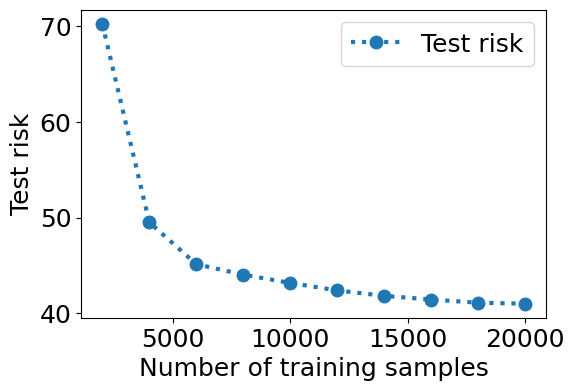

In [119]:
plt.figure(figsize=(6,4))
plt.plot(n_trains, lr_risks, 'o:', label='Test risk')
plt.xlabel('Number of training samples')
plt.ylabel('Test risk')
plt.legend()
plt.grid()
plt.show()

# Extra credit II: ridge regression

Now, implement a ridge regression predictor that takes

1. the number of i.i.d. training samples $768 < n \le 20000$ to be used in ERM and
2. a ridge parameter $\lambda = 10$ by default

as inputs and outputs the ERM minimizer $\hat{\theta}$ as a (lambda) function $f(x) = x^\top \hat{\theta}$

In [ ]:
ridge = 10
def ridge_regression(n_train, ridge=ridge):
    fea_train, lab_train = features[train_index[:n_train]], labels[train_index[:n_train]]
    # Implement ridge regression to find the ERM minimizer theta below
    U, s, Vh = torch.linalg.svd(fea_train, full_matrices=False)
    V = Vh.H
    ridge_diag = s/(s**2 + ridge)
    theta = V @ ((U.H @ lab_train).reshape(-1,1) * ridge_diag.reshape(-1,1))
    prediction = lambda x: (x @ theta).reshape(-1)
    return prediction

## Scaling law for ridge regression

In [122]:
n_trains = torch.arange(2000, 20001, 2000)
ridges = [100, 10, 1, 1e-1]
rr_risks = dict()
for ridge in ridges:
    rr_risks_ = torch.zeros(n_trains.shape)
    for i, n_train in enumerate(n_trains):
        prediction = ridge_regression(n_train, ridge=ridge)
        rr_risks_[i] = test_risk(prediction)
        print(f'Test risk with ridge={ridge:.0e}, n={n_train:d} samples: ', rr_risks_[i].item())
    rr_risks[ridge] = rr_risks_

Test risk with ridge=1e+02, n=2000 samples:  48.38072967529297
Test risk with ridge=1e+02, n=4000 samples:  44.46638870239258
Test risk with ridge=1e+02, n=6000 samples:  43.05698776245117
Test risk with ridge=1e+02, n=8000 samples:  42.568050384521484
Test risk with ridge=1e+02, n=10000 samples:  42.18686294555664
Test risk with ridge=1e+02, n=12000 samples:  41.699527740478516
Test risk with ridge=1e+02, n=14000 samples:  41.328773498535156
Test risk with ridge=1e+02, n=16000 samples:  41.04266357421875
Test risk with ridge=1e+02, n=18000 samples:  40.807559967041016
Test risk with ridge=1e+02, n=20000 samples:  40.716007232666016
Test risk with ridge=1e+01, n=2000 samples:  59.07884216308594
Test risk with ridge=1e+01, n=4000 samples:  47.7147331237793
Test risk with ridge=1e+01, n=6000 samples:  44.52723693847656
Test risk with ridge=1e+01, n=8000 samples:  43.644195556640625
Test risk with ridge=1e+01, n=10000 samples:  42.92671203613281
Test risk with ridge=1e+01, n=12000 samples

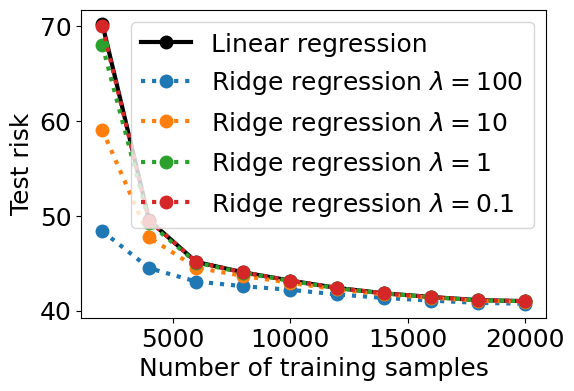

In [124]:
plt.figure(figsize=(6,4))
plt.plot(n_trains, lr_risks, 'ko-', label='Linear regression')
for ridge, rr_risks_ in rr_risks.items():
    plt.plot(n_trains, rr_risks_, 'o:', label=f'Ridge regression $\lambda={ridge}$')
plt.xlabel('Number of training samples')
plt.ylabel('Test risk')
plt.legend()
plt.grid()
plt.show()